### Open and view shape coastlal file

In [1]:
import glob
from pathlib import Path
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy.typing as npt
import geoplot as gplt
import itertools
import datetime 
import os
import cartopy
import numpy as np
from matplotlib import pyplot as plt
import math 
import sys
from datetime import datetime
from matplotlib.lines import Line2D
import matplotlib.text
from IPython.display import display
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression
import cartopy.crs as ccrs
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely import geometry, ops
from shapely.ops import split
import string

import shapefile
import fiona
from shapely.ops import unary_union
from shapely.ops import linemerge

import networkx

### Open and view coastline file

In [2]:
# Set filepath
fp = "ne_10m_coastline/ne_10m_coastline.shp"

# Read file using gpd.read_file()
data = gpd.read_file(fp)

display(data)

collect_data = []
for geom_line in data.geometry:
    collect_data.append(geom_line)

collect_segments = []
for data_line in collect_data:
    for index, point in enumerate(data_line.coords):
        collect_segments.append(point)               

        
#(collect_data[0])
gdf = gpd.GeoDataFrame(geometry=collect_data)

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."
1,Coastline,0,0.0,"LINESTRING (-51.73062 -82.06260, -52.18688 -82..."
2,Coastline,6,5.0,"LINESTRING (166.13697 -50.86435, 166.10711 -50..."
3,Coastline,0,0.0,"LINESTRING (-56.66832 -36.73642, -56.66487 -36..."
4,Coastline,0,0.0,"LINESTRING (-51.07939 3.49209, -51.09648 3.449..."
...,...,...,...,...
4128,Coastline,6,5.0,"LINESTRING (83.30511 70.80551, 83.37164 70.788..."
4129,Coastline,6,5.0,"LINESTRING (97.64568 76.75621, 97.64601 76.753..."
4130,Coastline,6,0.5,"LINESTRING (89.04713 77.14089, 89.13590 77.127..."
4131,Coastline,6,4.0,"LINESTRING (-66.77562 80.59858, -66.79027 80.5..."


In [ ]:
data.plot()

### Open bathymetry files : GEBCO 

In [3]:
# Load low-resolution GEBCO bathymetry
dir_current = os.getcwdb()
os.chdir(Path(Path('/home')/Path('eshchekinova')/Path('miniconda3')/Path('test_traj_AIS')/Path('global-AIS-traj')))
dir_in = Path(Path('GEBCOBATHY')/ Path('downscaled'))
dir_in.mkdir(parents=True, exist_ok=True)
# read model data from netcdf daily files
input_files = sorted(dir_in.glob(f"*.nc"))
def netcdf_2xarray(input_files):
    # convert files in nc directory to dataset using xarray
    ds = xr.open_mfdataset(
            input_files,
       #     parallel=True,
            data_vars="minimal",
            combine="by_coords", 
    )
    return ds

ds_bathy_reduced = netcdf_2xarray(input_files)

mask_land = np.where(ds_bathy_reduced["elevation"]>=0, 1, 0)

ds_bathy_reduced = ds_bathy_reduced.assign(mask_land=(["lat", "lon"],mask_land))
os.chdir(dir_current)

### Some functionalities definitions and declaration of classes

In [4]:
def func_point_onland(ds_bath, point_lon, point_lat):
    delta_lon = np.diff(ds_bath["lat"].values).mean()
    delta_lat = np.diff(ds_bath["lon"].values).mean()
    
    lon_slice = slice(point_lon  - delta_lon, point_lon+ delta_lon)
    lat_slice = slice(point_lat  - delta_lat, point_lat+ delta_lat)
    return ds_bath.sel(lon=lon_slice, lat=lat_slice)["mask_land"].values.min()

def func_great_circle_lat(lon1, lon2, lat1, lat2, f):
    # Here latitude of points lying on great circle arc between two fixed given points are calculated   
    
    lat = np.zeros([model_param["number_stops"]-1, model_param["number_ports"],model_param["fleet_size"],np.size(f,2)])

    d = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2))

    for i in range(0,np.size(f,2)):
        A = np.sin((1 - f[:,:,i]) * d) / np.sin(d)
        B = np.sin(f[:,:,i] * d) / np.sin(d)
        x = A * np.cos(lat1) * np.cos(lon1) + B * np.cos(lat2) * np.cos(lon2)
        y = A * np.cos(lat1) * np.sin(lon1) + B * np.cos(lat2) * np.sin(lon2)
        z = A * np.sin(lat1) + B * np.sin(lat2)

        lat[:,:,:,i] = np.arctan2(z,np.sqrt(x**2 + y**2))
    
    return lat 

def func_great_circle_lon_short(lon1, lon2, lat1, lat2, f):
    # Here longitude of points lying on great circle arc between two fixed given points are calculated   
    
    d = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2))
    lon = np.zeros([np.size(f,-1)])
    
    
  #  print(model_param["number_time_steps"]-2*model_param["time_steps_seed"]+1)
    for i in range(0,np.size(f, -1)):
        A = np.sin((1 - f[i]) * d) / np.sin(d)
        B = np.sin(f[i] * d) / np.sin(d)
        x = A * np.cos(lat1) * np.cos(lon1) + B * np.cos(lat2) * np.cos(lon2)
        y = A * np.cos(lat1) * np.sin(lon1) + B * np.cos(lat2) * np.sin(lon2)
        z = A * np.sin(lat1) + B * np.sin(lat2)
    
        lon[i] = np.where(abs(x)>0, np.arctan2(y,x),np.pi/2)
    
    return lon 

def is_land_edge(edge):
    return edge[2][1] == "land"

class PointHash(Point):
    def __hash__(self):
        return hash(self.coords[0])
    
    
class LineStringHash(LineString):
    def __hash__(self):
        return hash(tuple(self.coords))
    
def split_path_segments(data_coast=None, line_path=None, ds_bath = None):
    
    points_inter = []
    # Define list collection of all linestrings in data_coast
    collect_data = []
    pos_marked = []
  
    for geom_line in data.geometry:
        collect_data.append(geom_line)
   
    new_line_path = line_path  
    pos_marked.append("ocean")
    df_path_marked = pd.DataFrame(columns =['position', 'geom'])  
  
    for data_line in collect_data:
#    if (i < 50):
  #      collect_lines_without_split_points.append(data_line)     
  #      line_segments = list(map(LineString, zip(data_line.coords[:-1], data_line.coords[1:])))

  #      for line in line_segments:
        splits_0 = list(split(new_line_path, data_line).geoms)
        new_line_path = ops.linemerge(geometry.MultiLineString(split(new_line_path, data_line)))

      #  for pair_line in pairs(list(data_line.coords)):
      #      if cp == False:
      #          collect_data_left.append(pair_line[0])
      #      if cp == True:
      #          collect_data_right.append(pair_line[1])         
    if not (len(new_line_path.coords)==2):
        for i in range(len(new_line_path.coords)-1):
            ln = LineString([new_line_path.coords[i],new_line_path.coords[i+1]])
            if func_point_onland(ds_bath, (ln.coords[0][0]+ln.coords[1][0])/2,(ln.coords[0][1]+ln.coords[1][1])/2):
            #    print(type(df_path_marked))
                df_path_marked = df_path_marked.append({'position': "land", 'geom': ln}, ignore_index = True)
               # df_path_marked['geom'].append(ln_seg, ignore_index = True)
            else:
                df_path_marked = df_path_marked.append({'position': "ocean", 'geom': ln}, ignore_index = True)
            #    df_path_marked['position'].append("ocean")
            #    df_path_marked['geom'].append(ln_seg)             
    if df_path_marked.empty:
        df_path_marked.loc[0] = [pos_marked, new_line_path]
        
    return df_path_marked, new_line_path         
    
def split_coast_segments(data_coast=None, line_path=None, g_coast = None):
    # Find intersection with path and coastal data 
    # First split coastal data at the intersection of path, coastal data consisted of records of Linestrings
   
    collect_data = []
    for geom_line in data.geometry:
        collect_data.append(geom_line)
   
    collect_data_with_split_points = []
   
    for data_line in collect_data:
        data_line = split(data_line, line_path)
        for geom in data_line:
            collect_data_with_split_points.append(geom) 
      #  print(type(data_line))   
      #  for i in range(len(list(zip(data_line)))):   
      #      ln = LineString([(data_line.coords[0][0], data_line.coords[0][1]), (data_line.coords[1][0],data_line.coords[1][1])])
      #      collect_data_with_split_points.append(ln) 
    return collect_data_with_split_points         
def pairs(lst):
    for i in range(1, len(lst)):
        yield lst[i-1], lst[i]

In [ ]:
# Set filepath
#fp = "ne_10m_bathymetry_L_0/ne_10m_bathymetry_L_0.shp"

# Read file using gpd.read_file()
#bath_data = gpd.read_file(fp)

### Define destination and trajectory path

0 0
<class 'shapely.geometry.linestring.LineString'>


NameError: name 'vessel_marked_path' is not defined

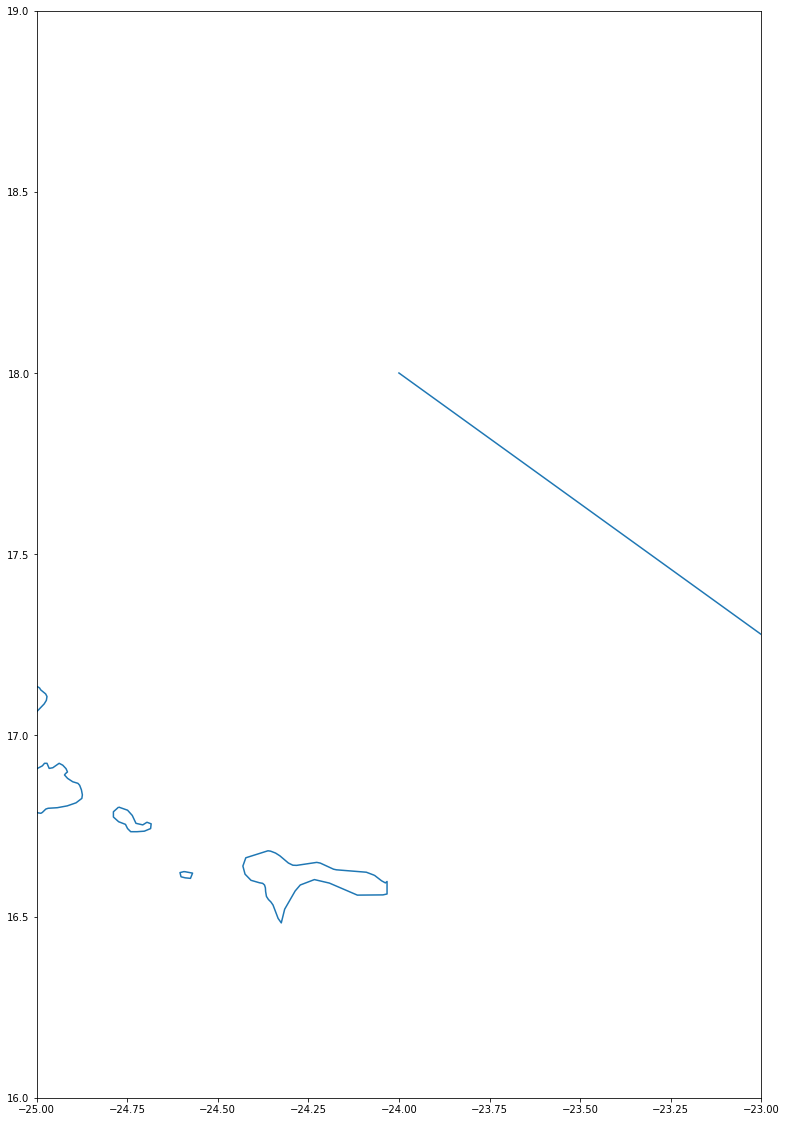

In [5]:
destinations = {
    "Azores": {"lon": -27.0, "lat": 38.0},
    "Florida Strait": {"lon": -79.0, "lat": 26.5},
    "English Channel": {"lon": -4.1, "lat": 49.5},
    "Miami": {"lon": -80.1, "lat": 25.8},
    "New York": {"lon": -73.5, "lat": 40.5},
    "Orkney": {"lon": -3.0, "lat": 59.0},
    "Savannah": {"lon": -80.0, "lat": 32.5},
    "Wilmington": {"lon": -77.5, "lat": 34.1},
}
vessel_path = LineString([(-24.0, 18.0),(3.3, -1.7)])

print(func_point_onland(ds_bathy_reduced, -24.0, 18.0),func_point_onland(ds_bathy_reduced, 3.3, -1.7))
#vessel_path = LineString([(destinations["Miami"]["lon"], destinations["Miami"]["lat"]), (destinations["English Channel"]["lon"], destinations["English Channel"]["lat"])])
print(type(vessel_path))
#plt.figure(figsize=(20,20))
data.plot(figsize=(20,20))
plt.xlim([-25,-23])
plt.ylim([16, 19])
plt.plot(*vessel_path.xy)
#for ln in vessel_marked_path["geom"]:
for i in range(len(vessel_marked_path.coords)-1):
    ln = LineString([vessel_marked_path.coords[i],vessel_marked_path.coords[i+1]])
    plt.plot(*ln.xy)

### Extract coast trajectory intersections and collect in a new set of Linestrings

   position                                               geom
0     ocean  LINESTRING (-24 18, -16.80145224413046 12.8054...
1     ocean  LINESTRING (-16.80145224413046 12.805443560782...
2     ocean  LINESTRING (-16.79049274426788 12.797535057218...
3     ocean  LINESTRING (-16.77268221817268 12.784682772820...
4      land  LINESTRING (-16.72373366666566 12.749360924297...
5      land  LINESTRING (-16.69945218743559 12.731839124266...
6     ocean  LINESTRING (-16.65149292116946 12.697231155569...
7     ocean  LINESTRING (-16.6382476851218 12.6876732379816...
8     ocean  LINESTRING (-16.60375337723267 12.662781741079...
9      land  LINESTRING (-16.51144564358193 12.596171398482...
10     land  LINESTRING (-16.12964599011395 12.320660293232...
11     land  LINESTRING (-16.12266803312686 12.315624917677...
12    ocean  LINESTRING (-15.54458434857608 11.898472954833...
13     land  LINESTRING (-15.46340144478575 11.839890419863...
14     land  LINESTRING (-15.28835101748981 11.71357197

(12.0, 13.0)

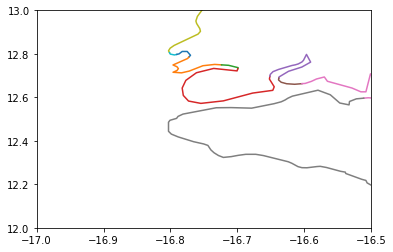

In [27]:
collect_coast = split_coast_segments(collect_data, vessel_path, ds_bathy_reduced)
df_path, vessel_marked_path = split_path_segments(data, vessel_path, ds_bathy_reduced)

collect_coast_intersect =[]


for ln in collect_coast:
    plt.plot(*ln.xy)
# generate a series of linestring segments from germany bounday
#gs_l = gpd.GeoSeries(
#    [
#        shapely.geometry.LineString(list(ls.coords)[s : s + 4])
#        for s in np.random.randint(0, len(list(ls.coords)) - 4, 6)
#    ], crs="epsg:4326"
#)

# folium
#m = gs_l.explore(style_kwds={"weight":6}, height=400, width=400)
#gs_l.centroid.explore(m=m, color="red", marker_kwds={"radius":10})

# matplotlib
#ax = gs_l.plot()
#ax = gs_l.centroid.plot(color="red", markersize=50, ax=ax)

#(collect_data[0])
#gdf = gpd.GeoDataFrame(geometry=collect_data_with_split_points)

#gdf.plot()
print(df_path)
plt.xlim([-17,-16.5])
plt.ylim([12, 13])

In [ ]:
for ln in list(zip(df_path["geom"])):
    print(ln[0])
#for index in range(df_path.shape[0]):
#    print(type(df_path["geom"][index]))
#for ln_seg, pos in [list(zip(df_path["geom"])), list(zip(df_path["position"]))]:
#    print(ln_seg, pos)

### Define graph networks containg vessel path without land and coastal data

In [7]:
g_path = networkx.MultiGraph()
i=0
len_vessel_path = df_path.shape[0]-1
print(len_vessel_path)
for index in range(df_path.shape[0]):
    ln_seg = df_path["geom"][index]
    pos_seg = df_path["position"][index]
    if  pos_seg == "ocean":
         g_path.add_edge(#ln_seg.coords[0],ln_seg.coords[-1])
               PointHash(ln_seg.coords[0]),
               PointHash(ln_seg.coords[-1]),
               key=LineStringHash(ln_seg),
       )
for ln_seg in collect_coast:
        g_path.add_edge(#_seg.coords[0],ln_seg.coords[-1])
           PointHash(ln_seg.coords[0]),
           PointHash(ln_seg.coords[-1]),
            key=LineStringHash(ln_seg),
        )        

24


In [104]:
i=0

print(g_path.edges)

[((-24.0, 18.0), (-16.801452244130463, 12.805443560782788), 0), ((-16.801452244130463, 12.805443560782788), (-16.790492744267883, 12.79753505721895), 0), ((-16.790492744267883, 12.79753505721895), (-16.77268221817268, 12.78468277282058), 0), ((-16.77268221817268, 12.78468277282058), (-16.72373366666566, 12.749360924297196), 0), ((-16.65149292116946, 12.69723115556917), (-16.6382476851218, 12.687673237981665), 0), ((-16.6382476851218, 12.687673237981665), (-16.603753377232668, 12.662781741079982), 0), ((-16.603753377232668, 12.662781741079982), (-16.511445643581933, 12.5961713984822), 0), ((-15.54458434857608, 11.89847295483329), (-15.463401444785754, 11.839890419863712), 0), ((-5.973247195320554, 4.991683873546334), (3.3, -1.7), 0)]


### Merge segments of network and plot it

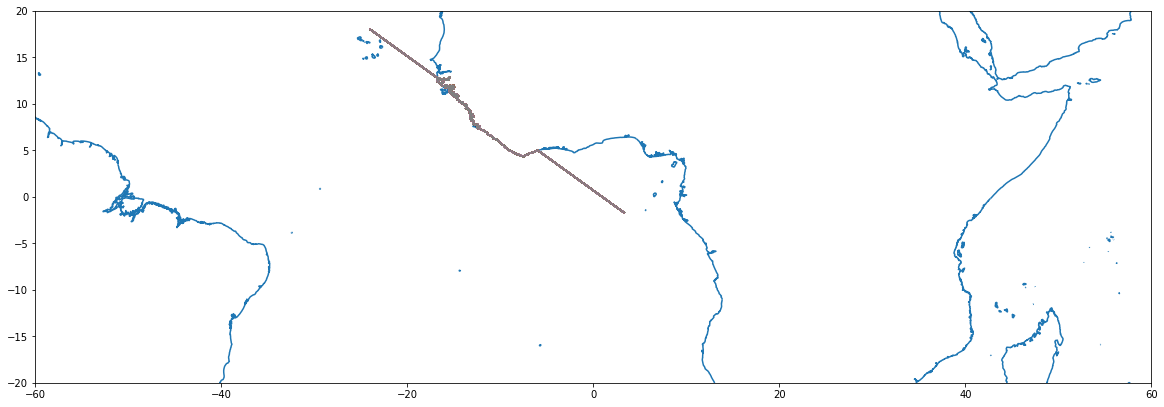

In [20]:
start_point_path = Point(vessel_marked_path.coords[0][0],vessel_marked_path.coords[0][1])
end_point_path = Point(vessel_marked_path.coords[25][0],vessel_marked_path.coords[25][1])

#for _p in networkx.all_simple_edge_paths(g_path, PointHash(start_point_path), PointHash(end_point_path)):
#networkx.draw(g_path)
data.plot(figsize=(20,20))
for _p in networkx.all_simple_edge_paths(g_path, PointHash(start_point_path), PointHash(end_point_path)):    
    plt.plot(*linemerge([_l[2] for _l in _p]).xy)

plt.xlim([-60,60])
plt.ylim([-20, 20])
dir_figures = Path('Figures')
if not os.path.exists(dir_figures):
    os.makedirs(dir_figures)
   
plt.savefig('{}/CoastAfrica.jpg'.format(dir_figures),
                    format='jpg',dpi=150) 

0


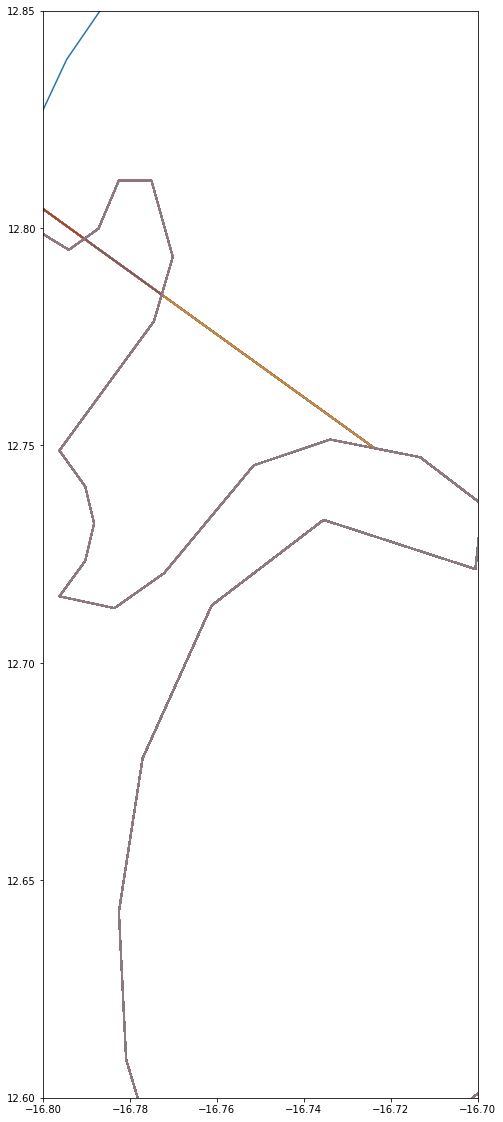

In [38]:


#networkx.draw(g_path)
data.plot(figsize=(20,20))
for _p in networkx.all_simple_edge_paths(g_path, PointHash(start_point_path), PointHash(end_point_path)):    
    plt.plot(*linemerge([_l[2] for _l in _p]).xy)

plt.xlim([-16.8,-16.7])
plt.ylim([12.6, 12.85])

   
plt.savefig('{}/CoastAfrica_detail.jpg'.format(dir_figures),
                    format='jpg',dpi=150) 
print(func_point_onland(ds_bathy_reduced, -16.75,12.77))


### Exra 

In [ ]:
import geopandas as gpd
import shapely.geometry
import numpy as np


world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# exteriod of germany
ls = world.loc[world["iso_a3"].isin(["DEU"])].exterior.values[0]

# generate a series of linestring segments from germany bounday
gs_l = gpd.GeoSeries(
    [
        shapely.geometry.LineString(list(ls.coords)[s : s + 4])
        for s in np.random.randint(0, len(list(ls.coords)) - 4, 6)
    ], crs="epsg:4326"
)

# folium
m = gs_l.explore(style_kwds={"weight":6}, height=400, width=400)
gs_l.centroid.explore(m=m, color="red", marker_kwds={"radius":10})

# matplotlib
ax = gs_l.plot()
ax = gs_l.centroid.plot(color="red", markersize=50, ax=ax)